In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tqdm.autonotebook import tqdm as notebook_tqdm
# importing the data
from data import *
X = X.T
Y = Y.T
x_train = np.array([*X[:40],*Y[:40]])
x_test = np.array([*X[40:],*Y[40:]])
y_train = np.ones(80)
y_train[40:] = -np.ones(40)
y_test = np.ones(20)
y_test[10:] = -np.ones(10)


TSNE

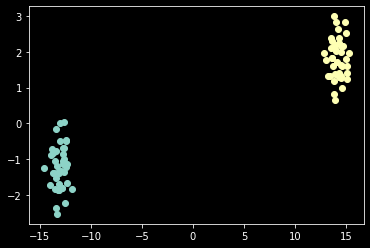

In [15]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=30, n_iter = 1000).fit_transform(x_train)

plt.scatter(X_embedded[:40,0],X_embedded[:40,1], label='X')
plt.scatter(X_embedded[40:,0],X_embedded[40:,1], label='Y')
plt.show()

SVM

In [16]:
from sklearn import svm

accuracy = lambda predicted, label: np.mean(predicted==label)

clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy(y_pred, y_test)

1.0

In [17]:
print(2/np.linalg.norm(clf.coef_))

117.73902605644058


SVM gives an accuracy of 1

Now, our own svm trained using subgradient method

In [18]:
accuracy = lambda predicted, label: torch.mean((predicted==label).float())

import torch
class svm:
    @classmethod
    def __init__(self, trade_off: int = 10):
        self.w = None
        self.b = None
        self.trade_off = torch.tensor(trade_off)
        self.learning_rate = None
        

    @staticmethod
    def shuffle(train: torch.tensor, labels: torch.tensor):
        """
        Shuffles the data in a random permutation
        """
        n = train.shape[0]
        permutation = torch.randperm(n)
        train = train[permutation]
        labels = labels[permutation]
        return train, labels
    
    @staticmethod
    def iterate_minibatches(train : torch.tensor, labels: torch.tensor, batch_size : int):
        """
        Gives minibatches
        """
        for start_idx in range(0, train.shape[0] + 1 - batch_size, batch_size):
            excerpt = slice(start_idx, start_idx+batch_size)
            yield train[excerpt], labels[excerpt]

    
    @classmethod
    def fit_util(self, train: torch.tensor, labels: torch.tensor):
        """
        Utility function for fit
        """
        
        indices = (labels * (train @ self.w + self.b )) < 1.
        # n = torch.sqrt(4/(self.w@self.w))
        grad_b = -torch.sum(labels[indices])
        grad_w = 2 * self.w  - self.trade_off * (labels[indices] @ train[indices])
        self.b -=  self.learning_rate * grad_b
        self.w -= self.learning_rate * grad_w
        if n>100:
            print((labels[indices] @ train[indices]))
            print(torch.sqrt(4/(self.w@self.w)))

    @classmethod
    def fit(self, train, labels, learning_rate : int = 0.1 ,epochs : int = 10, batch_size = 10):
        """
        Trains the weights
        """
        self.learning_rate = torch.tensor(learning_rate)
        s = train.shape[1]
        self.w = torch.normal(torch.zeros(s)).to(torch.float64)
        self.b = torch.tensor(0.).to(torch.float64)
        

        for epoch in range(epochs):
            self.learning_rate = 1/(epoch+1)
            train, labels = self.shuffle(train, labels)
            for x,y in self.iterate_minibatches(train, labels, batch_size):
                self.fit_util(x, y)

    @classmethod
    def predict(self, test):
        """
        returns the predicted label
        """
        logits = test @ self.w + self.b
        return torch.sign(logits)



In [19]:

x_train_ = torch.tensor(x_train)
x_test_ = torch.tensor(x_test)
y_train_ = torch.tensor(y_train)
y_test_ = torch.tensor(y_test)

clf = svm(0.0003)
clf.fit(x_train_, y_train_, epochs = 20, batch_size = 4, learning_rate = 0.1)
print(x_test_ @ clf.w + clf.b)
y_pred = clf.predict(x_test_)
print("The accuracy of our model is {}".format(accuracy(y_pred, y_test_)))

tensor([ 0.9572,  1.1508,  1.0628,  0.9374,  1.3040,  1.0761,  0.9887,  1.1928,
         1.0451,  1.1355, -0.9625, -0.8612, -1.0348, -1.0082, -1.0248, -1.1893,
        -1.0225, -1.0941, -0.9355, -1.1935], dtype=torch.float64)
The accuracy of our model is 1.0


In [20]:
torch.sqrt(4/(clf.w@clf.w))

tensor(128.4273, dtype=torch.float64)

The problem with above implementation is that a steady step size can often cause increase in value of the objective function

Possible solutions

1. 

In [48]:
accuracy = lambda predicted, label: torch.mean((predicted==label).float())

import torch
class svm:
    @classmethod
    def __init__(self, trade_off: int = 10):
        self.w = None
        self.b = None
        self.trade_off = torch.tensor(trade_off)
        self.learning_rate = None
        self.epsilon = 0.001
        self.best_w = None
        self.best_b = None
        self.opt_cost = 1e9
        

    @staticmethod
    def shuffle(train: torch.tensor, labels: torch.tensor):
        """
        Shuffles the data in a random permutation
        """
        n = train.shape[0]
        permutation = torch.randperm(n)
        train = train[permutation]
        labels = labels[permutation]
        return train, labels
    
    @staticmethod
    def iterate_minibatches(train : torch.tensor, labels: torch.tensor, batch_size : int):
        """
        Gives minibatches
        """
        for start_idx in range(0, train.shape[0] + 1 - batch_size, batch_size):
            excerpt = slice(start_idx, start_idx+batch_size)
            yield train[excerpt], labels[excerpt]

    @classmethod
    def cost(self, train, labels):
        return self.w @ self.w + np.maximum( 0 , 1 - labels @ (train @ self.w + self.b))

    
    @classmethod
    def fit_util(self, train: torch.tensor, labels: torch.tensor):
        """
        Utility function for fit
        """
        indices = (labels * (train @ self.w + self.b )) < 1.
        grad_b = -torch.sum(labels[indices])
        grad_w = 2 * self.w  - self.trade_off * (labels[indices] @ train[indices])
        self.b -=  self.learning_rate * grad_b
        self.w -= self.learning_rate * grad_w / self.trade_off
        if self.opt_cost > self.cost(train, labels):
            self.best_b = self.b
            self.best_w = self.w
            self.opt_cost = self.cost(train, labels)
    @classmethod
    def fit(self, train, labels, learning_rate : int = 0.1 ,epochs : int = 10, batch_size = 10):
        """
        Trains the weights
        """
        self.learning_rate = torch.tensor(learning_rate)
        s = train.shape[1]
        self.w = torch.normal(torch.zeros(s)).to(torch.float64)
        self.b = torch.tensor(0.).to(torch.float64)
        
        for epoch in range(epochs):
            train, labels = self.shuffle(train, labels)
            for x,y in self.iterate_minibatches(train, labels, batch_size):
                self.fit_util(x, y)
        self.w = self.best_w
        self.b = self.best_b
                

    @classmethod
    def predict(self, test):
        """
        returns the predicted label
        """
        logits = test @ self.w + self.b
        return torch.sign(logits)



In [49]:

x_train_ = torch.tensor(x_train)
x_test_ = torch.tensor(x_test)
y_train_ = torch.tensor(y_train)
y_test_ = torch.tensor(y_test)

clf = svm(1)
clf.epsilon = 1e-5
clf.fit(x_train_, y_train_, epochs = 50000, batch_size = 4, learning_rate = 0.00005)
print(x_test_ @ clf.w + clf.b)
y_pred = clf.predict(x_test_)
print("The accuracy of our model is {}".format(accuracy(y_pred, y_test_)))

tensor([ 1.2111,  1.4387,  1.2645,  1.2299,  1.5661,  1.2885,  1.3092,  1.4331,
         1.3294,  1.4665, -1.2325, -1.0683, -1.3352, -1.2045, -1.3057, -1.4026,
        -1.1853, -1.3557, -1.1751, -1.5006], dtype=torch.float64)
The accuracy of our model is 1.0


In [42]:
torch.sqrt(4/(clf.w@clf.w))

tensor(104.3989, dtype=torch.float64)